In [1]:
import numpy as np              # numpy is a general-purpose math package
import yt                       # yt is the data vizualization package
from yt.units import *          # this lets you get things like speed of light in proper units just by typing 'c'
from astropy.table import Table # this is needed for reading in various foggie data byproducts
from astropy.io import ascii    # this too
import matplotlib.pyplot as plt # this is the standard python plotting package, very useful!
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
import math
from ipynb.fs.defs.FRB_and_Projection_functions import frb_projection, projection
from scipy import optimize
import pwlf # A library for fitting continuous piecewise linear functions to data (Returns cut-off radius)
import os #for the lacie part 

# These imports are FOGGIE-specific files
from foggie.utils.consistency import *
from foggie.utils.foggie_load import *

home_dir = '/Users/hylee/foggie/'
laptop_root_dir = home_dir + 'foggie_sims/' # root directory where sims are stored on the laptop
hd_root_dir = '/Volumes/LaCie/' # root directory where sims are stored on the hard drive

root_dir = hd_root_dir # have this as either laptop_root_dir or hd_root_dir depending on where the simulation is stored
code_path = '/Users/hylee/coding/foggie/foggie/' #path to the cloned github repo

# everything above this is general path, and below this is specific to a given halo
halo = '8508' # which halo
simulation_dir = root_dir + 'halo_00' + halo + '/nref11c_nref9f/' # path where the foggie simulations are stored
output_dir = home_dir + 'foggie_output/halo_00' + halo + '/nref11c_nref9f/' # path where all the outputs will be stored
track_dir = code_path + 'halo_infos/00' + halo + '/nref11c_nref9f/'
track_name = code_path + 'halo_tracks/00' + halo + '/nref11n_selfshield_15/halo_track_200kpc_nref9' #these need to be provided to foggie_load()

In [2]:
def radius_func(od, size, res):
    OD_Qua=[]
    OD_Rad=[]  #OD_Rad & OD_Met HAVE to be defined specifically inside func1/before for loop
    for i in range(70):
        for j in range(70):
            this_quantity_value = od[i][j]
            xindex = i
            yindex = j
            radius = (math.sqrt(((yindex-34)**2+(xindex-34)**2)))*(size/res)
            OD_Qua.append(this_quantity_value)
            OD_Rad.append(radius)
    return OD_Rad, OD_Qua

In [3]:
def binning_func(OD_Rad, OD_Qua, max_radius, min_radius, binsize):
    index = 0 
    quantitylist = []
    sort = np.argsort(OD_Rad)
    sorted_radius = np.array(OD_Rad)[sort]
    sorted_quantity = np.array(OD_Qua)[sort]
    radiuslist = np.arange(min_radius, max_radius, binsize) + binsize/2
    while index < len(radiuslist):
        left_edge = index*binsize
        right_edge = left_edge + binsize 
        new_quantity = np.array(sorted_quantity)[(left_edge <= sorted_radius) & (sorted_radius < right_edge)]
        quantitylist.append((np.mean(new_quantity)))
        index +=1
    return radiuslist, quantitylist

In [4]:
def piecewise_linear(x, x0, y0, k1, k2): 
    return np.piecewise(x, [x < x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])

In [5]:
def plotting(xvalue, yvalue_origdata, yvalue_cutoff, color_original, color_cutoff, plotlabel_linedot,
            plotlabel_segment):
    fig1 = plt.figure()
    plt.plot(xvalue, yvalue_origdata, color_original, label=plotlabel_linedot)
    plt.plot(xvalue, yvalue_cutoff, color_cutoff, label=plotlabel_segment)
    plt.legend(loc="upper right", fontsize = 15)
    plt.xlabel("Radius from galactic center [kpc]", fontsize = fontsize)
    plt.ylabel("Density [log 10 g/cm^2]", fontsize = fontsize)

    plt.xticks(fontsize = fontsize/1.5)
    plt.yticks(fontsize = fontsize/1.5)
    return fig1

In [6]:
def get_density_cut(current_time):
    t1, t2 = 8.628, 10.754 # Gyr; corresponds to z1 = 0.5 and z2 = 0.25
    rho1, rho2 = 2e-26, 2e-27 # g/cm**3
    t = np.float64(current_time)
    rho_cut = np.piecewise(t, [t < t1, (t >= t1) & (t <= t2), t > t2], [rho1, lambda t: rho1 + (t - t1) * (rho2 - rho1) / (t2 - t1), rho2])
    return rho_cut

In [7]:
DDLIST = []
for file in os.listdir(simulation_dir):
    if file.startswith("DD"):
        DDLIST.append(file)
sorted_dd_list = sorted(DDLIST, key=lambda x: int(x[2:]))

In [8]:
field = "density"
axis = "y" 
resolution = 70 #[pixel]
colorlabel = 'Density [log 10 g/cm^2]'
min_radius = 0  #[kpc]
binsize = 1.5 #[kpc]
markersize = 10
fontsize = 20 
plotlabel_linedot = 'Binned mean density'

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0138/DD0138


yt : [INFO     ] 2023-07-21 16:11:35,029 Parameters: current_time              = 67.566527818285
yt : [INFO     ] 2023-07-21 16:11:35,031 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-21 16:11:35,033 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-21 16:11:35,034 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-21 16:11:35,034 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-21 16:11:35,035 Parameters: current_redshift          = 4.2560468529995
yt : [INFO     ] 2023-07-21 16:11:35,036 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-21 16:11:35,036 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-21 16:11:35,037 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-21 16:11:35,037 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:     col1      col2     col3     col4     col5     col6     col7   col8
----------- -------- -------- -------- -------- -------- -------- ----
4.256046853 0.494908 0.492937 0.500048 0.496908 0.494937 0.502048    9


Parsing Hierarchy : 100%|█████████████████| 5116/5116 [00:00<00:00, 8822.47it/s]
yt : [INFO     ] 2023-07-21 16:11:35,907 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-21 16:12:40,460 Projection completed
yt : [INFO     ] 2023-07-21 16:12:40,464 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70
yt : [INFO     ] 2023-07-21 16:12:40,566 Parameters: current_time              = 92.566527818285
yt : [INFO     ] 2023-07-21 16:12:40,567 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-21 16:12:40,567 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-21 16:12:40,568 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-21 16:12:40,568 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-21 16:12:40,569 Parameters: current_redshift          = 3.2538800161868
yt : [INFO     ] 2023-07-21 16:12:40,569 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-21 16:12:40,570 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-21 16:12:40,571 Parameters: omega_radiation           = 0.0
yt : [INFO     ]

Error with DD0138
Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0238/DD0238
get_refine_box: using this location:      col1       col2     col3     col4     col5     col6     col7   col8
------------- -------- -------- -------- -------- -------- -------- ----
3.25388001619 0.494301 0.491267 0.500132 0.496301 0.493267 0.502132    9


Parsing Hierarchy : 100%|██████████████| 11675/11675 [00:01<00:00, 10572.24it/s]
yt : [INFO     ] 2023-07-21 16:12:42,061 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-21 16:15:07,203 Projection completed
yt : [INFO     ] 2023-07-21 16:15:07,205 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/unyt/array.py:1802: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


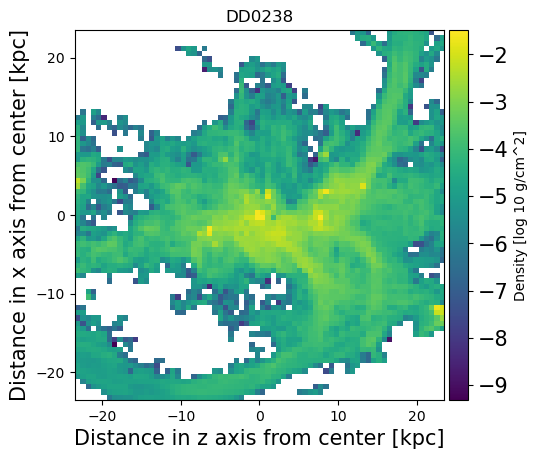

yt : [INFO     ] 2023-07-21 16:15:07,915 Parameters: current_time              = 104.81652781829
yt : [INFO     ] 2023-07-21 16:15:07,916 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-21 16:15:07,916 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-21 16:15:07,917 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-21 16:15:07,918 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-21 16:15:07,919 Parameters: current_redshift          = 2.9116806075987
yt : [INFO     ] 2023-07-21 16:15:07,919 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-21 16:15:07,920 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-21 16:15:07,921 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-21 16:15:07,921 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0287/DD0287
get_refine_box: using this location:     col1       col2     col3     col4     col5     col6     col7   col8
------------ -------- -------- -------- -------- -------- -------- ----
2.9116806076 0.493954 0.490721 0.500203 0.495954 0.492721 0.502203    9


Parsing Hierarchy : 100%|█████████████████| 7384/7384 [00:00<00:00, 9037.41it/s]
yt : [INFO     ] 2023-07-21 16:15:09,029 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-21 16:16:33,327 Projection completed
yt : [INFO     ] 2023-07-21 16:16:33,328 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/unyt/array.py:1802: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


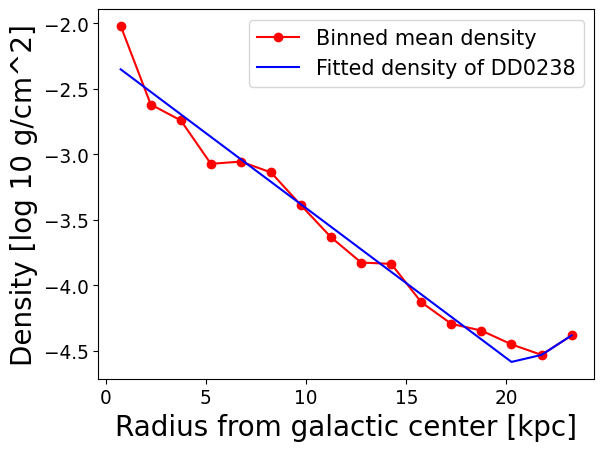

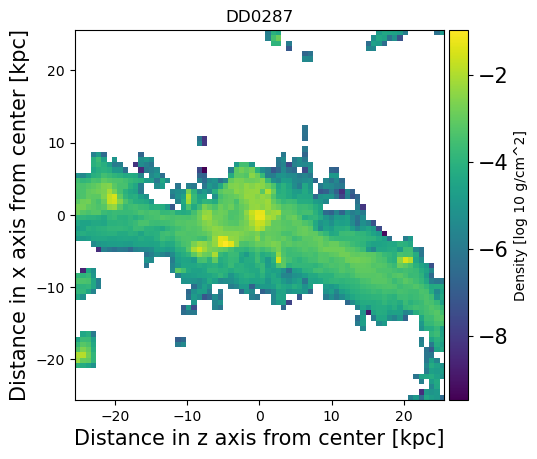

yt : [INFO     ] 2023-07-21 16:16:34,138 Parameters: current_time              = 106.31652781829
yt : [INFO     ] 2023-07-21 16:16:34,138 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-21 16:16:34,139 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-21 16:16:34,140 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-21 16:16:34,141 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-21 16:16:34,141 Parameters: current_redshift          = 2.8742891413864
yt : [INFO     ] 2023-07-21 16:16:34,142 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-21 16:16:34,143 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-21 16:16:34,144 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-21 16:16:34,144 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0293/DD0293
get_refine_box: using this location:      col1       col2     col3     col4    col5     col6     col7  col8
------------- -------- -------- ------- -------- -------- ------- ----
2.87428914139 0.493962 0.490687 0.50017 0.495962 0.492687 0.50217    9


Parsing Hierarchy : 100%|█████████████████| 7297/7297 [00:01<00:00, 5641.45it/s]
yt : [INFO     ] 2023-07-21 16:16:35,717 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-21 16:18:04,464 Projection completed
yt : [INFO     ] 2023-07-21 16:18:04,466 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/unyt/array.py:1802: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


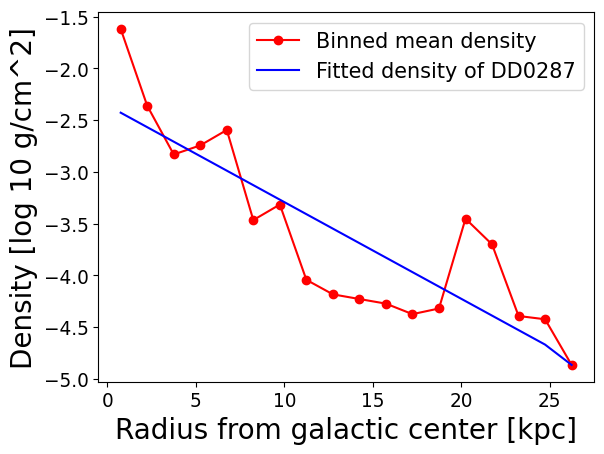

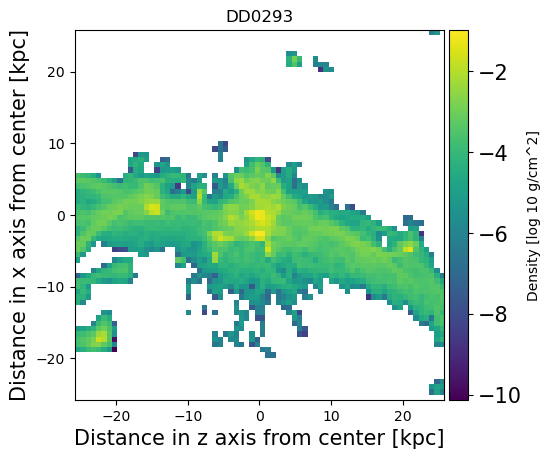

yt : [INFO     ] 2023-07-21 16:18:05,045 Parameters: current_time              = 117.56652781829
yt : [INFO     ] 2023-07-21 16:18:05,046 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-21 16:18:05,046 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-21 16:18:05,047 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-21 16:18:05,048 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-21 16:18:05,049 Parameters: current_redshift          = 2.6192132579666
yt : [INFO     ] 2023-07-21 16:18:05,049 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-21 16:18:05,050 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-21 16:18:05,050 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-21 16:18:05,051 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0338/DD0338
get_refine_box: using this location:      col1       col2     col3     col4     col5     col6     col7   col8
------------- -------- -------- -------- -------- -------- -------- ----
2.61921325797 0.493773 0.490067 0.500353 0.495773 0.492067 0.502353    9


Parsing Hierarchy : 100%|█████████████████| 8624/8624 [00:01<00:00, 8556.67it/s]
yt : [INFO     ] 2023-07-21 16:18:06,427 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-21 16:19:42,381 Projection completed
yt : [INFO     ] 2023-07-21 16:19:42,383 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/unyt/array.py:1802: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


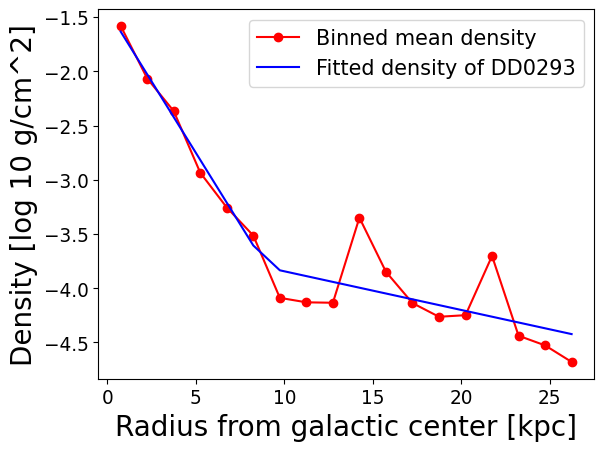

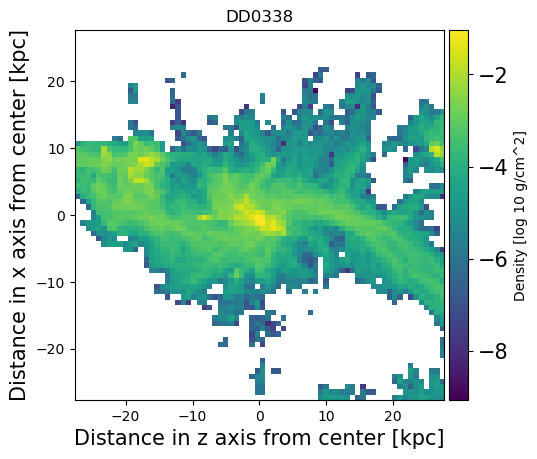

yt : [INFO     ] 2023-07-21 16:19:42,964 Parameters: current_time              = 142.56652781829
yt : [INFO     ] 2023-07-21 16:19:42,965 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-21 16:19:42,965 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-21 16:19:42,966 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-21 16:19:42,967 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-21 16:19:42,968 Parameters: current_redshift          = 2.174064272558
yt : [INFO     ] 2023-07-21 16:19:42,968 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-21 16:19:42,969 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-21 16:19:42,969 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-21 16:19:42,970 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0438/DD0438
get_refine_box: using this location:      col1       col2     col3     col4     col5     col6     col7   col8
------------- -------- -------- -------- -------- -------- -------- ----
2.17406427256 0.493252 0.488579 0.500941 0.495252 0.490579 0.502941    9


Parsing Hierarchy : 100%|████████████████| 9619/9619 [00:00<00:00, 11591.02it/s]
yt : [INFO     ] 2023-07-21 16:19:44,109 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-21 16:21:32,568 Projection completed
yt : [INFO     ] 2023-07-21 16:21:32,570 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/unyt/array.py:1802: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


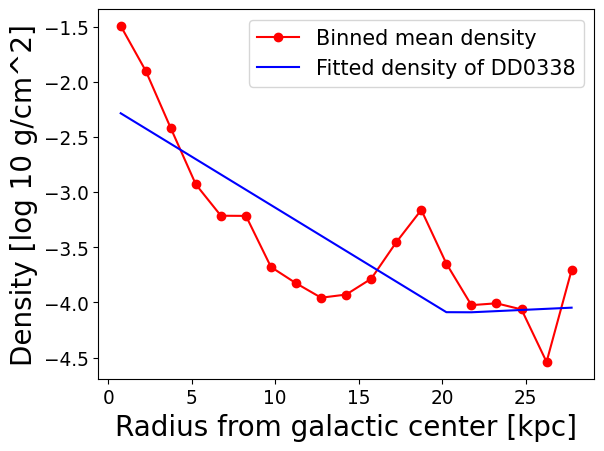

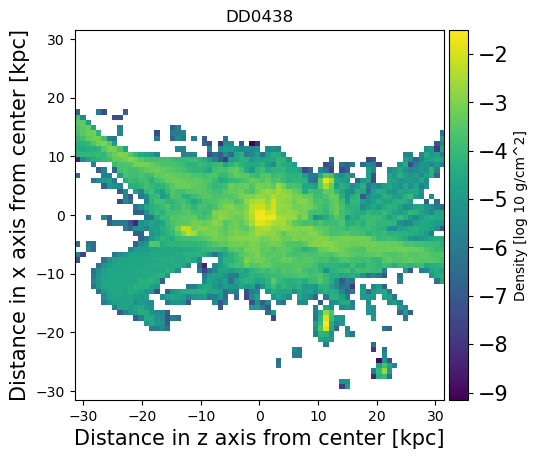

yt : [INFO     ] 2023-07-21 16:21:33,385 Parameters: current_time              = 167.56652781829
yt : [INFO     ] 2023-07-21 16:21:33,386 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-21 16:21:33,387 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-21 16:21:33,388 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-21 16:21:33,389 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-21 16:21:33,389 Parameters: current_redshift          = 1.8407728906142
yt : [INFO     ] 2023-07-21 16:21:33,390 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-21 16:21:33,391 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-21 16:21:33,391 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-21 16:21:33,392 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0538/DD0538
get_refine_box: using this location:      col1       col2     col3     col4     col5     col6     col7   col8
------------- -------- -------- -------- -------- -------- -------- ----
1.84077289061 0.492796 0.487204 0.501442 0.494796 0.489204 0.503442    9


Parsing Hierarchy : 100%|█████████████████| 6003/6003 [00:00<00:00, 6650.59it/s]
yt : [INFO     ] 2023-07-21 16:21:34,601 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-21 16:22:50,695 Projection completed
yt : [INFO     ] 2023-07-21 16:22:50,696 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/unyt/array.py:1802: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


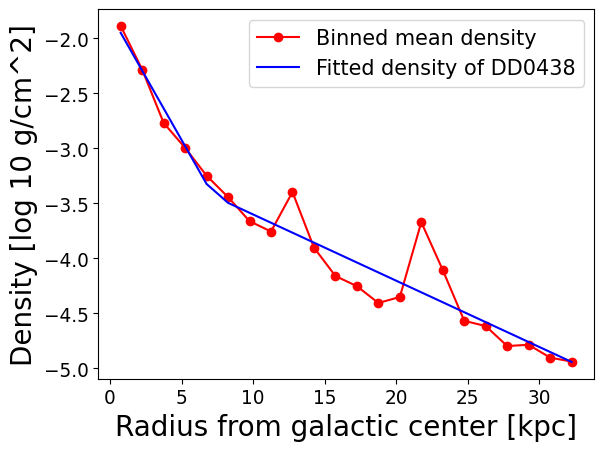

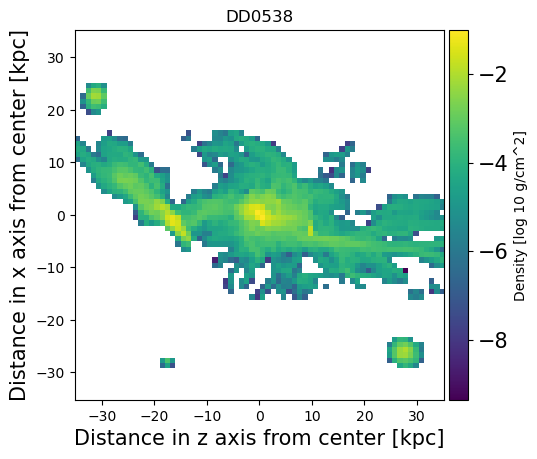

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0638/DD0638


yt : [INFO     ] 2023-07-21 16:22:51,479 Parameters: current_time              = 192.56652781829
yt : [INFO     ] 2023-07-21 16:22:51,480 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-21 16:22:51,481 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-21 16:22:51,482 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-21 16:22:51,482 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-21 16:22:51,483 Parameters: current_redshift          = 1.5796008591072
yt : [INFO     ] 2023-07-21 16:22:51,483 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-21 16:22:51,484 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-21 16:22:51,484 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-21 16:22:51,485 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:      col1       col2    col3     col4     col5    col6     col7   col8
------------- ------- -------- -------- ------- -------- -------- ----
1.57960085911 0.49248 0.485831 0.501973 0.49448 0.487831 0.503973    9


Parsing Hierarchy : 100%|█████████████████| 7363/7363 [00:01<00:00, 5078.78it/s]
yt : [INFO     ] 2023-07-21 16:22:53,231 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-21 16:24:24,041 Projection completed
yt : [INFO     ] 2023-07-21 16:24:24,042 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/unyt/array.py:1802: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


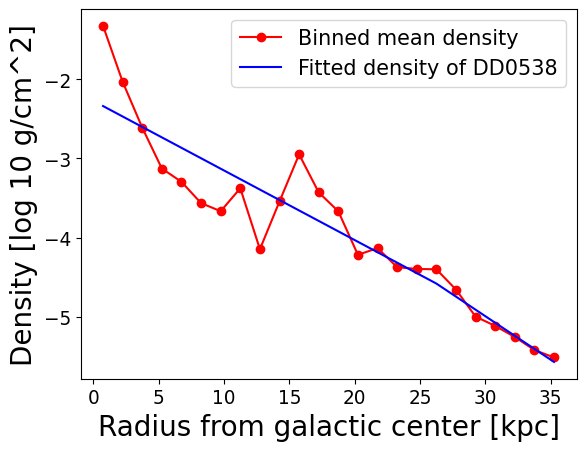

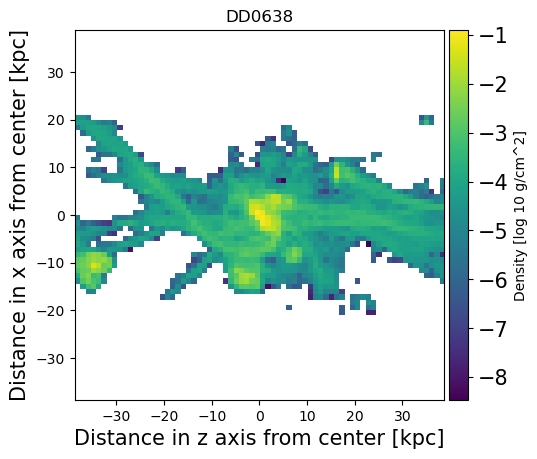

yt : [INFO     ] 2023-07-21 16:24:24,674 Parameters: current_time              = 217.56652781829
yt : [INFO     ] 2023-07-21 16:24:24,675 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-21 16:24:24,675 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-21 16:24:24,676 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-21 16:24:24,676 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-21 16:24:24,677 Parameters: current_redshift          = 1.3679320867642
yt : [INFO     ] 2023-07-21 16:24:24,678 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-21 16:24:24,679 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-21 16:24:24,679 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-21 16:24:24,680 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0738/DD0738
get_refine_box: using this location:      col1       col2    col3     col4    col5    col6     col7  col8
------------- ------- -------- ------- ------- -------- ------- ----
1.36793208676 0.49219 0.484532 0.50256 0.49419 0.486532 0.50456    9


Parsing Hierarchy : 100%|████████████████| 8207/8207 [00:00<00:00, 11199.08it/s]
yt : [INFO     ] 2023-07-21 16:24:26,100 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-21 16:26:02,594 Projection completed
yt : [INFO     ] 2023-07-21 16:26:02,595 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/unyt/array.py:1802: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


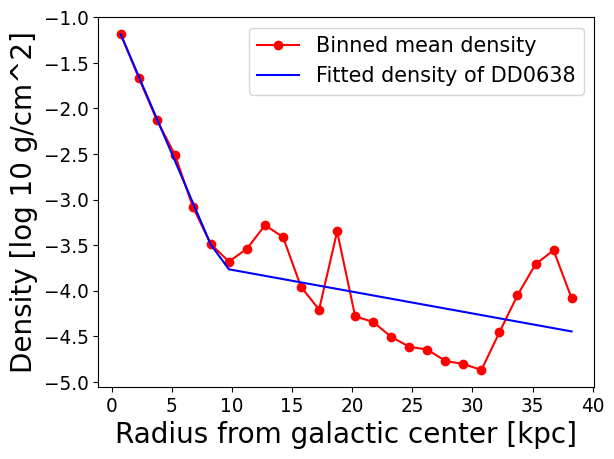

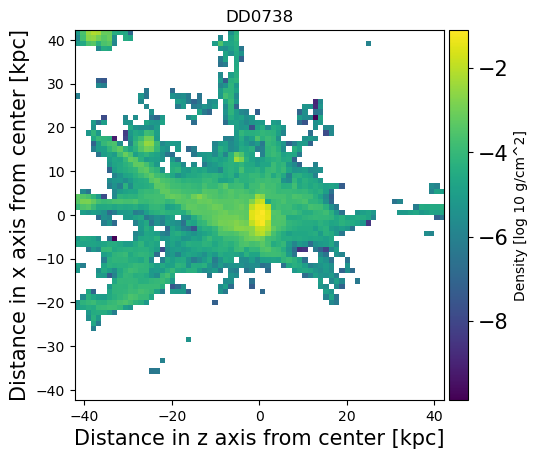

yt : [INFO     ] 2023-07-21 16:26:03,350 Parameters: current_time              = 242.56652781829
yt : [INFO     ] 2023-07-21 16:26:03,351 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-21 16:26:03,351 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-21 16:26:03,352 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-21 16:26:03,353 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-21 16:26:03,354 Parameters: current_redshift          = 1.1918720434881
yt : [INFO     ] 2023-07-21 16:26:03,354 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-21 16:26:03,355 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-21 16:26:03,356 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-21 16:26:03,357 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0838/DD0838
get_refine_box: using this location:      col1       col2    col3     col4     col5    col6     col7   col8
------------- ------- -------- -------- ------- -------- -------- ----
1.19187204349 0.49185 0.483393 0.503033 0.49385 0.485393 0.505033    9


Parsing Hierarchy : 100%|█████████████████| 6414/6414 [00:00<00:00, 8303.42it/s]
yt : [INFO     ] 2023-07-21 16:26:04,421 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-21 16:27:24,239 Projection completed
yt : [INFO     ] 2023-07-21 16:27:24,240 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/unyt/array.py:1802: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


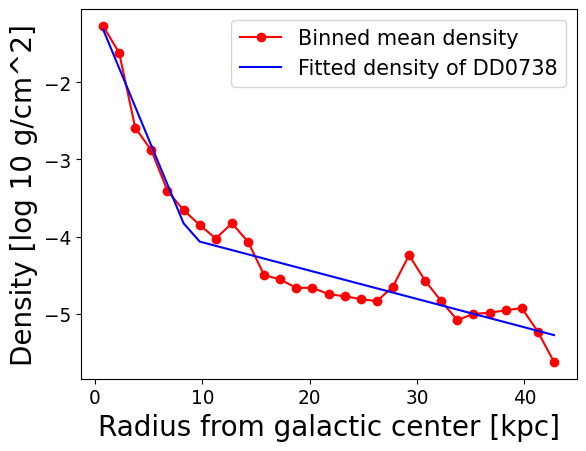

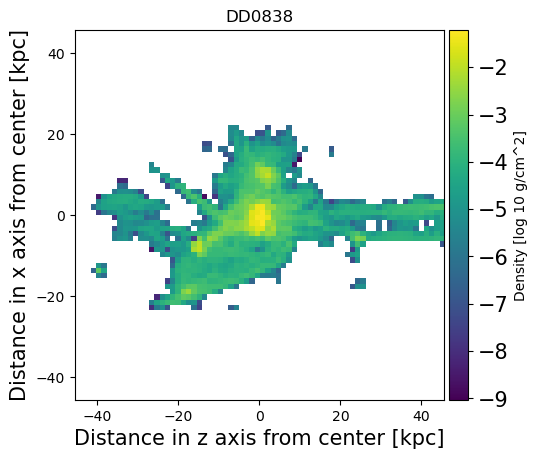

yt : [INFO     ] 2023-07-21 16:27:24,796 Parameters: current_time              = 267.56652781829
yt : [INFO     ] 2023-07-21 16:27:24,797 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-21 16:27:24,797 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-21 16:27:24,798 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-21 16:27:24,799 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-21 16:27:24,799 Parameters: current_redshift          = 1.0423765498971
yt : [INFO     ] 2023-07-21 16:27:24,799 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-21 16:27:24,800 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-21 16:27:24,800 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-21 16:27:24,801 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0938/DD0938
get_refine_box: using this location:     col1       col2     col3     col4     col5     col6     col7   col8
------------ -------- -------- -------- -------- -------- -------- ----
1.0423765499 0.491558 0.482256 0.503483 0.493558 0.484256 0.505483    9


Parsing Hierarchy : 100%|█████████████████| 6646/6646 [00:00<00:00, 7309.77it/s]
yt : [INFO     ] 2023-07-21 16:27:25,959 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-21 16:28:44,431 Projection completed
yt : [INFO     ] 2023-07-21 16:28:44,432 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/unyt/array.py:1802: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


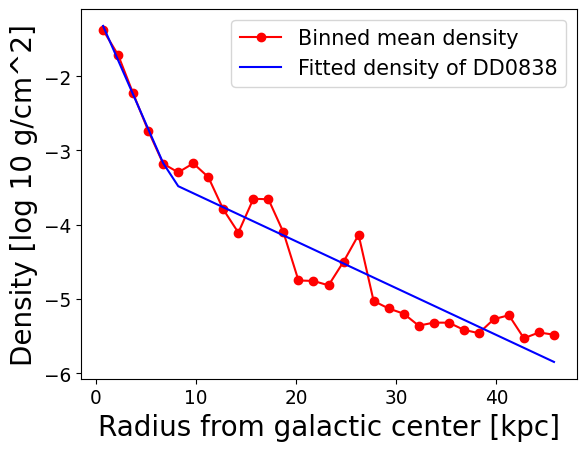

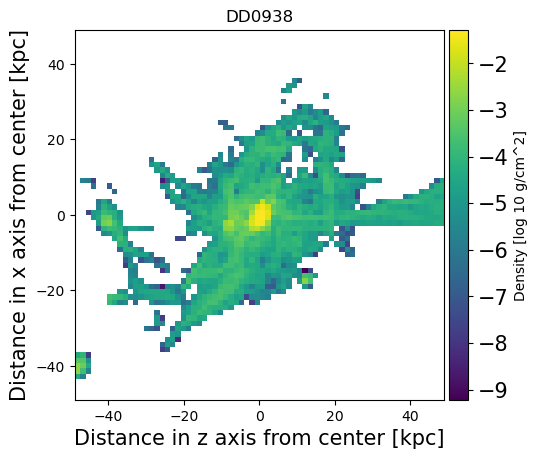

yt : [INFO     ] 2023-07-21 16:28:44,983 Parameters: current_time              = 292.31652781829
yt : [INFO     ] 2023-07-21 16:28:44,984 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-21 16:28:44,984 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-21 16:28:44,985 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-21 16:28:44,986 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-21 16:28:44,987 Parameters: current_redshift          = 0.91449134314195
yt : [INFO     ] 2023-07-21 16:28:44,987 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-21 16:28:44,988 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-21 16:28:44,989 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-21 16:28:44,990 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1038/DD1038
get_refine_box: using this location:      col1        col2     col3     col4     col5     col6     col7   col8
-------------- -------- -------- -------- -------- -------- -------- ----
0.914491343142 0.491324 0.481173 0.503918 0.493324 0.483173 0.505918    9


Parsing Hierarchy : 100%|█████████████████| 5369/5369 [00:01<00:00, 4412.77it/s]
yt : [INFO     ] 2023-07-21 16:28:46,547 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-21 16:29:59,340 Projection completed
yt : [INFO     ] 2023-07-21 16:29:59,341 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/unyt/array.py:1802: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


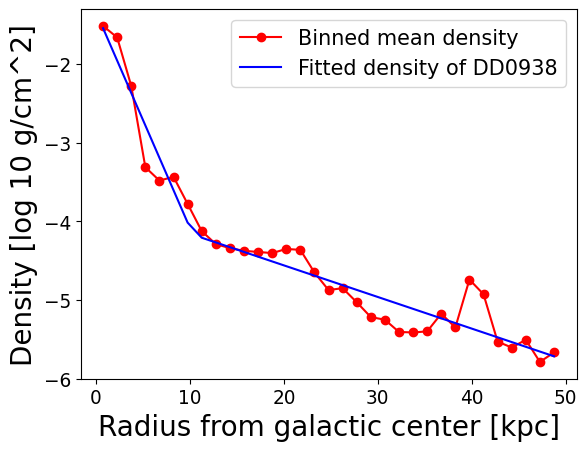

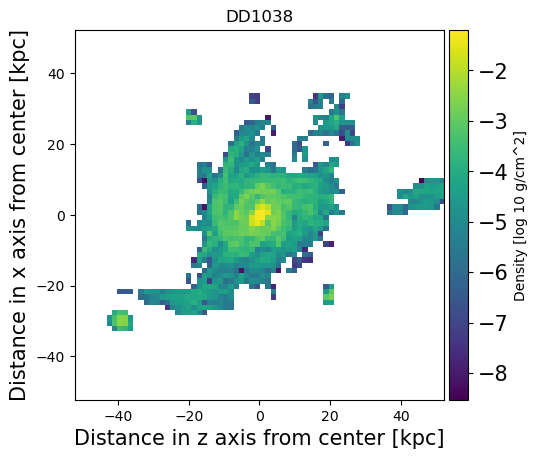

yt : [INFO     ] 2023-07-21 16:29:59,891 Parameters: current_time              = 317.31652781829
yt : [INFO     ] 2023-07-21 16:29:59,892 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-21 16:29:59,893 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-21 16:29:59,894 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-21 16:29:59,895 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-21 16:29:59,895 Parameters: current_redshift          = 0.80131183964773
yt : [INFO     ] 2023-07-21 16:29:59,896 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-21 16:29:59,897 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-21 16:29:59,898 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-21 16:29:59,898 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1138/DD1138
get_refine_box: using this location:       col1         col2    col3    col4     col5    col6    col7   col8
---------------- ------- ------- -------- ------- ------- -------- ----
0.80131183964773 0.49111 0.48016 0.504261 0.49311 0.48216 0.506261    9


Parsing Hierarchy : 100%|█████████████████| 5629/5629 [00:00<00:00, 9120.65it/s]
yt : [INFO     ] 2023-07-21 16:30:00,724 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-21 16:31:13,521 Projection completed
yt : [INFO     ] 2023-07-21 16:31:13,522 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/unyt/array.py:1802: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


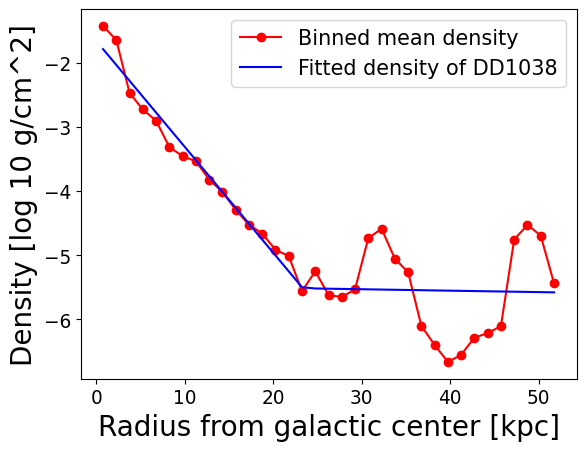

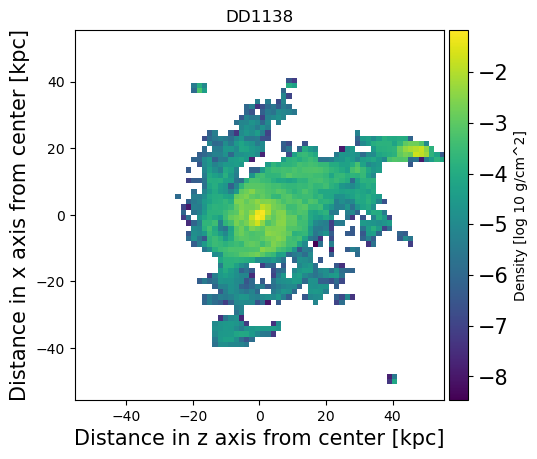

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1238/DD1238


yt : [INFO     ] 2023-07-21 16:31:14,346 Parameters: current_time              = 342.31652781829
yt : [INFO     ] 2023-07-21 16:31:14,347 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-21 16:31:14,348 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-21 16:31:14,349 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-21 16:31:14,350 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-21 16:31:14,351 Parameters: current_redshift          = 0.70104740107777
yt : [INFO     ] 2023-07-21 16:31:14,352 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-21 16:31:14,352 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-21 16:31:14,353 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-21 16:31:14,354 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:       col1         col2    col3     col4     col5    col6     col7   col8
---------------- ------- -------- -------- ------- -------- -------- ----
0.70104740107777 0.49091 0.479176 0.504679 0.49291 0.481176 0.506679    9


Parsing Hierarchy : 100%|█████████████████| 6009/6009 [00:00<00:00, 7388.80it/s]
yt : [INFO     ] 2023-07-21 16:31:15,415 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-21 16:32:12,858 Projection completed
yt : [INFO     ] 2023-07-21 16:32:12,860 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/unyt/array.py:1802: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


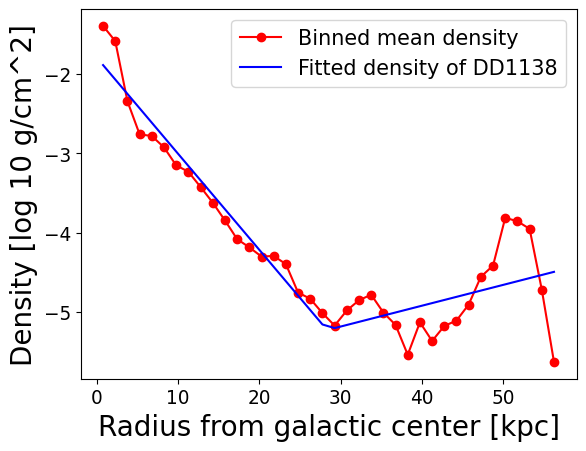

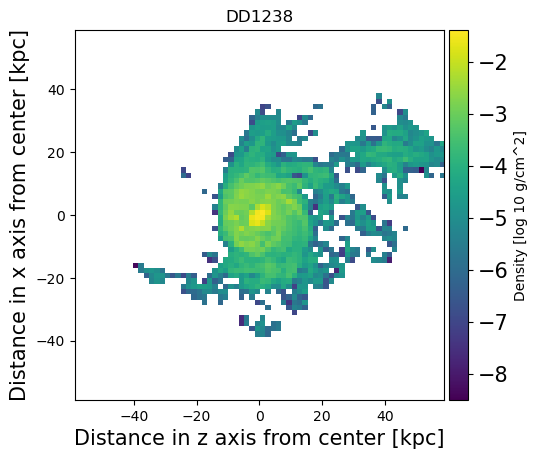

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1338/DD1338


yt : [INFO     ] 2023-07-21 16:32:13,838 Parameters: current_time              = 367.31652781829
yt : [INFO     ] 2023-07-21 16:32:13,839 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-21 16:32:13,840 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-21 16:32:13,840 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-21 16:32:13,841 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-21 16:32:13,842 Parameters: current_redshift          = 0.61132831909135
yt : [INFO     ] 2023-07-21 16:32:13,842 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-21 16:32:13,843 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-21 16:32:13,844 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-21 16:32:13,844 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:       col1         col2     col3    col4     col5     col6    col7   col8
---------------- -------- ------- -------- -------- ------- -------- ----
0.61132831909135 0.490681 0.47823 0.505093 0.492681 0.48023 0.507093    9


Parsing Hierarchy : 100%|█████████████████| 6366/6366 [00:00<00:00, 6642.10it/s]
yt : [INFO     ] 2023-07-21 16:32:15,121 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-21 16:33:01,144 Projection completed
yt : [INFO     ] 2023-07-21 16:33:01,145 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/unyt/array.py:1802: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


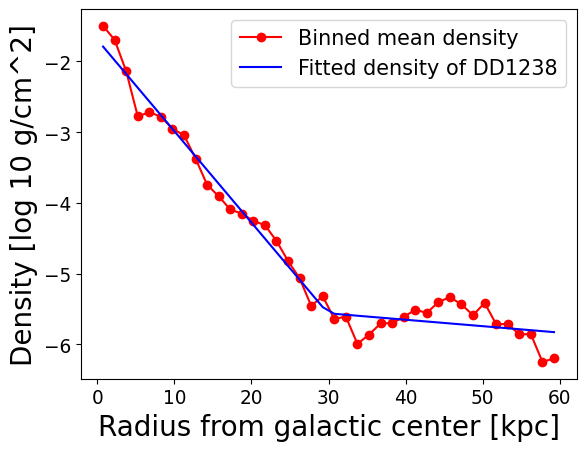

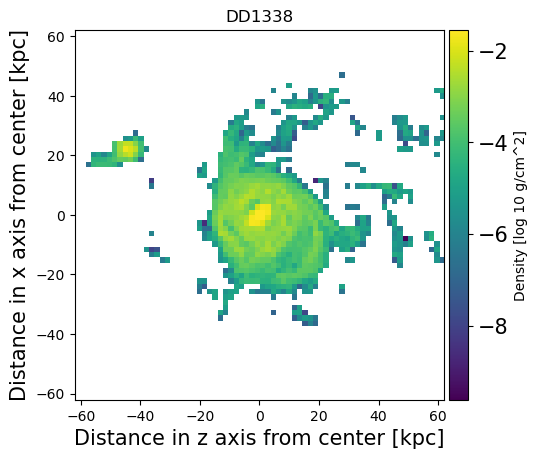

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1438/DD1438


yt : [INFO     ] 2023-07-21 16:33:01,989 Parameters: current_time              = 392.31652781829
yt : [INFO     ] 2023-07-21 16:33:01,990 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-21 16:33:01,991 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-21 16:33:01,991 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-21 16:33:01,992 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-21 16:33:01,993 Parameters: current_redshift          = 0.53034842583426
yt : [INFO     ] 2023-07-21 16:33:01,994 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-21 16:33:01,994 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-21 16:33:01,995 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-21 16:33:01,996 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:       col1         col2     col3     col4     col5     col6     col7   col8
---------------- -------- -------- -------- -------- -------- -------- ----
0.53034842583426 0.490464 0.477354 0.505497 0.492464 0.479354 0.507497    9


Parsing Hierarchy : 100%|█████████████████| 6029/6029 [00:00<00:00, 7077.47it/s]
yt : [INFO     ] 2023-07-21 16:33:03,098 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-21 16:33:58,071 Projection completed
yt : [INFO     ] 2023-07-21 16:33:58,072 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/unyt/array.py:1802: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


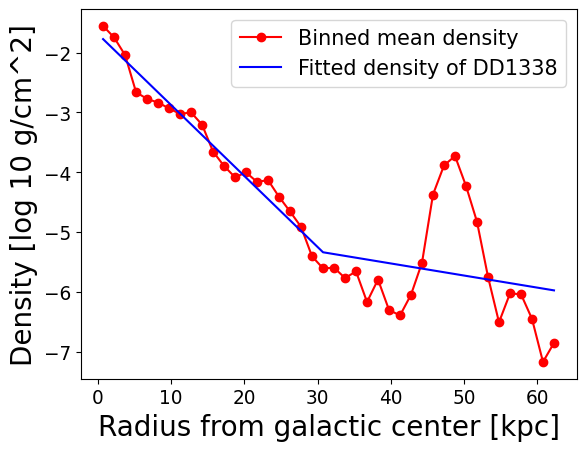

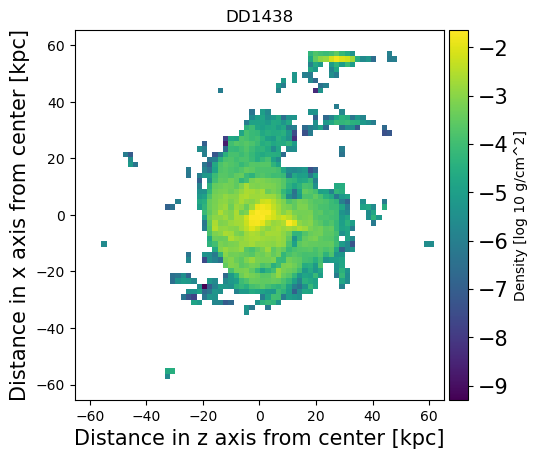

yt : [INFO     ] 2023-07-21 16:33:58,825 Parameters: current_time              = 402.06652781829
yt : [INFO     ] 2023-07-21 16:33:58,826 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-21 16:33:58,827 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-21 16:33:58,827 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-21 16:33:58,828 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-21 16:33:58,829 Parameters: current_redshift          = 0.50082158855578
yt : [INFO     ] 2023-07-21 16:33:58,830 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-21 16:33:58,831 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-21 16:33:58,831 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-21 16:33:58,832 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1477/DD1477
get_refine_box: using this location:       col1         col2     col3     col4     col5     col6     col7   col8
---------------- -------- -------- -------- -------- -------- -------- ----
0.50082158855578 0.490382 0.477019 0.505663 0.492382 0.479019 0.507663    9


Parsing Hierarchy : 100%|█████████████████| 6066/6066 [00:01<00:00, 4539.37it/s]
yt : [INFO     ] 2023-07-21 16:34:00,434 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-21 16:35:20,414 Projection completed
yt : [INFO     ] 2023-07-21 16:35:20,415 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/hylee/anaconda3/lib/python3.10/site-packages/unyt/array.py:1802: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


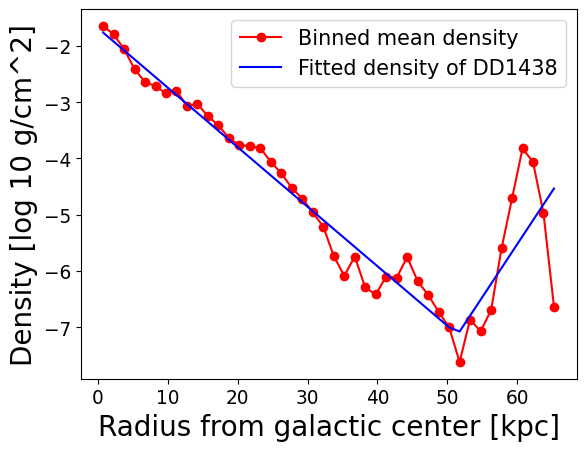

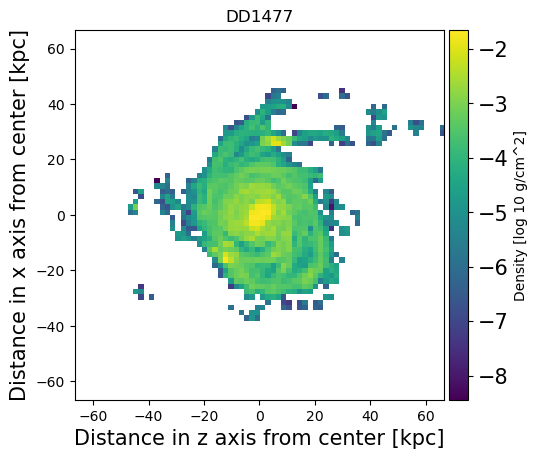

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1478/DD1478


yt : [INFO     ] 2023-07-21 16:35:21,273 Parameters: current_time              = 402.31652781829
yt : [INFO     ] 2023-07-21 16:35:21,273 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-21 16:35:21,274 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-21 16:35:21,275 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-21 16:35:21,276 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-21 16:35:21,277 Parameters: current_redshift          = 0.50007848881181
yt : [INFO     ] 2023-07-21 16:35:21,278 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-21 16:35:21,278 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-21 16:35:21,279 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-21 16:35:21,280 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:       col1         col2    col3     col4     col5    col6     col7   col8
---------------- ------- -------- -------- ------- -------- -------- ----
0.50007848881181 0.49038 0.477011 0.505667 0.49238 0.479011 0.507667    9


Parsing Hierarchy : 100%|█████████████████| 5947/5947 [00:00<00:00, 9449.23it/s]
yt : [INFO     ] 2023-07-21 16:35:22,113 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-21 16:36:40,950 Projection completed
yt : [INFO     ] 2023-07-21 16:36:40,951 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/unyt/array.py:1802: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


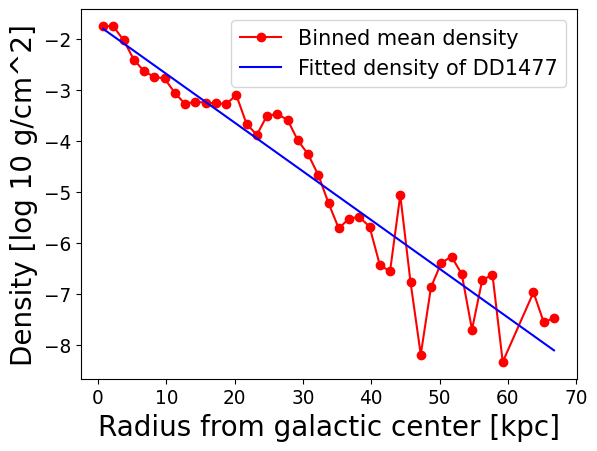

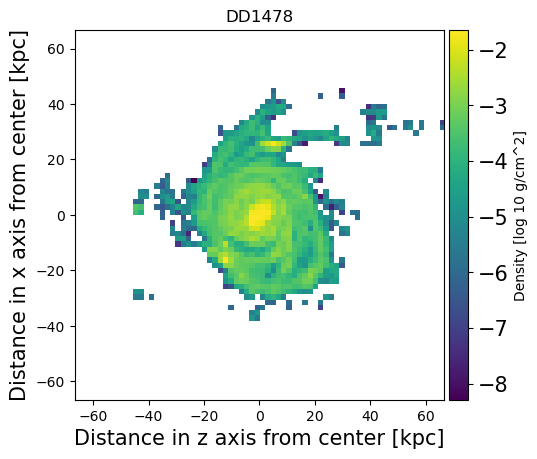

yt : [INFO     ] 2023-07-21 16:36:41,988 Parameters: current_time              = 402.56652517609
yt : [INFO     ] 2023-07-21 16:36:41,988 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-21 16:36:41,989 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-21 16:36:41,990 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-21 16:36:41,991 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-21 16:36:41,992 Parameters: current_redshift          = 0.49933608114367
yt : [INFO     ] 2023-07-21 16:36:41,993 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-21 16:36:41,994 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-21 16:36:41,994 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-21 16:36:41,995 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1479/DD1479
get_refine_box: using this location:       col1         col2     col3     col4     col5     col6     col7   col8
---------------- -------- -------- -------- -------- -------- -------- ----
0.49933608114367 0.490378 0.477002 0.505671 0.492378 0.479002 0.507671    9


Parsing Hierarchy : 100%|█████████████████| 5985/5985 [00:00<00:00, 7367.62it/s]
yt : [INFO     ] 2023-07-21 16:36:43,056 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-21 16:38:01,496 Projection completed
yt : [INFO     ] 2023-07-21 16:38:01,498 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/hylee/anaconda3/lib/python3.10/site-packages/unyt/array.py:1802: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


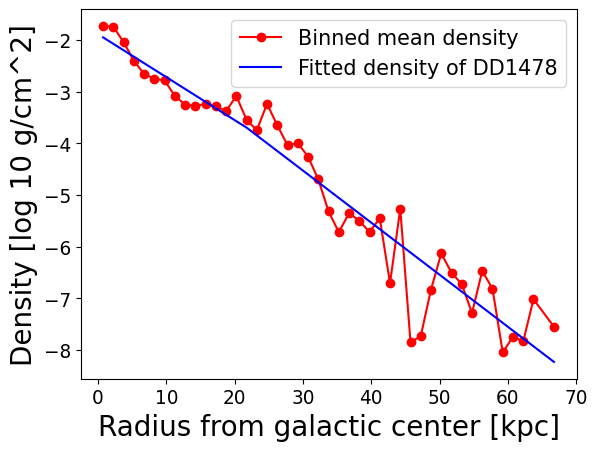

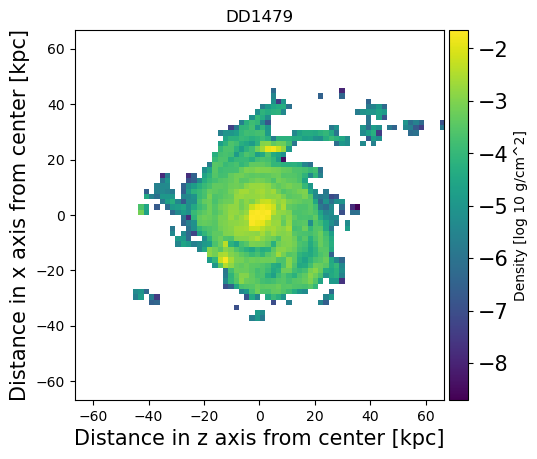

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1538/DD1538


yt : [INFO     ] 2023-07-21 16:38:02,754 Parameters: current_time              = 417.31652781829
yt : [INFO     ] 2023-07-21 16:38:02,755 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-21 16:38:02,756 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-21 16:38:02,756 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-21 16:38:02,757 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-21 16:38:02,758 Parameters: current_redshift          = 0.45670560906839
yt : [INFO     ] 2023-07-21 16:38:02,759 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-21 16:38:02,759 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-21 16:38:02,760 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-21 16:38:02,761 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:       col1         col2     col3     col4     col5     col6     col7   col8
---------------- -------- -------- -------- -------- -------- -------- ----
0.45670560906839 0.490252 0.476517 0.505875 0.492252 0.478517 0.507875    9


Parsing Hierarchy : 100%|█████████████████| 6119/6119 [00:00<00:00, 7952.88it/s]
yt : [INFO     ] 2023-07-21 16:38:03,829 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-21 16:39:23,153 Projection completed
yt : [INFO     ] 2023-07-21 16:39:23,155 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/unyt/array.py:1802: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


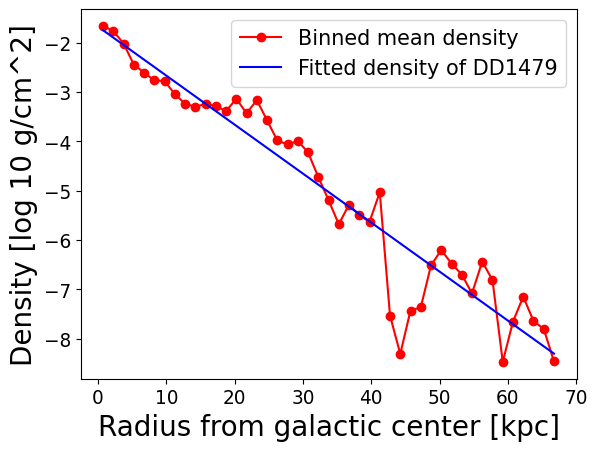

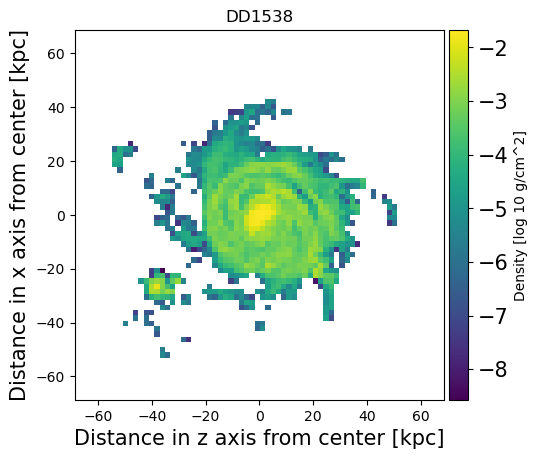

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1638/DD1638


yt : [INFO     ] 2023-07-21 16:39:23,840 Parameters: current_time              = 442.31652781829
yt : [INFO     ] 2023-07-21 16:39:23,841 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-21 16:39:23,842 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-21 16:39:23,843 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-21 16:39:23,844 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-21 16:39:23,845 Parameters: current_redshift          = 0.3892837031507
yt : [INFO     ] 2023-07-21 16:39:23,846 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-21 16:39:23,847 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-21 16:39:23,847 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-07-21 16:39:23,848 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:       col1         col2     col3     col4     col5     col6     col7   col8
---------------- -------- -------- -------- -------- -------- -------- ----
0.38929394169243 0.490071 0.475697 0.506226 0.492071 0.477697 0.508226    9


Parsing Hierarchy : 100%|█████████████████| 5613/5613 [00:00<00:00, 8761.25it/s]
yt : [INFO     ] 2023-07-21 16:39:24,720 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-21 16:40:35,476 Projection completed
yt : [INFO     ] 2023-07-21 16:40:35,477 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/hylee/anaconda3/lib/python3.10/site-packages/unyt/array.py:1802: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


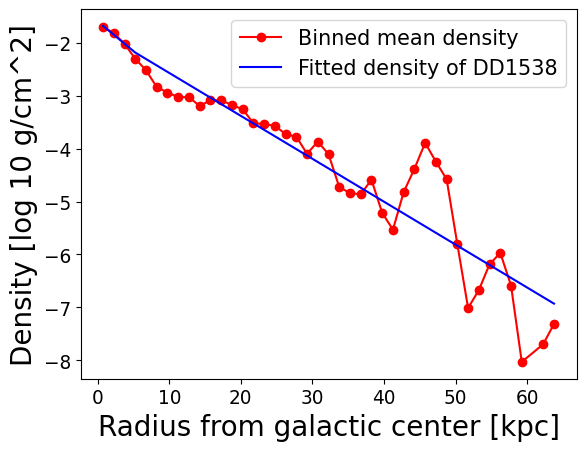

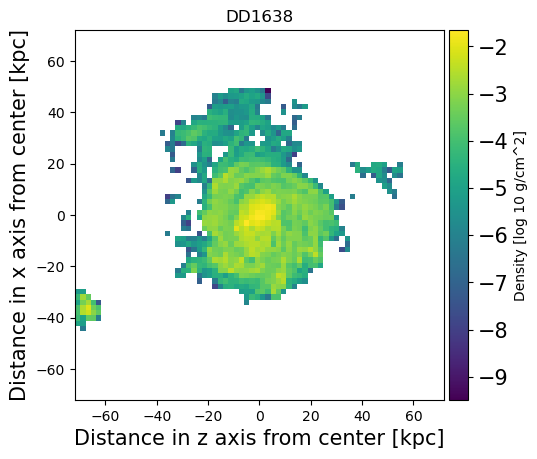

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1738/DD1738


yt : [INFO     ] 2023-07-21 16:40:36,364 Parameters: current_time              = 467.31652781829
yt : [INFO     ] 2023-07-21 16:40:36,365 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-21 16:40:36,365 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-21 16:40:36,366 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-21 16:40:36,368 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-21 16:40:36,368 Parameters: current_redshift          = 0.32721407621449
yt : [INFO     ] 2023-07-21 16:40:36,369 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-21 16:40:36,370 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-21 16:40:36,371 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-07-21 16:40:36,372 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:       col1         col2     col3     col4     col5     col6     col7   col8
---------------- -------- -------- -------- -------- -------- -------- ----
0.32722883488872 0.489878 0.474896 0.506564 0.491878 0.476896 0.508564    9


Parsing Hierarchy : 100%|█████████████████| 5309/5309 [00:00<00:00, 7118.83it/s]
yt : [INFO     ] 2023-07-21 16:40:37,334 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-21 16:41:44,211 Projection completed
yt : [INFO     ] 2023-07-21 16:41:44,213 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/unyt/array.py:1802: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


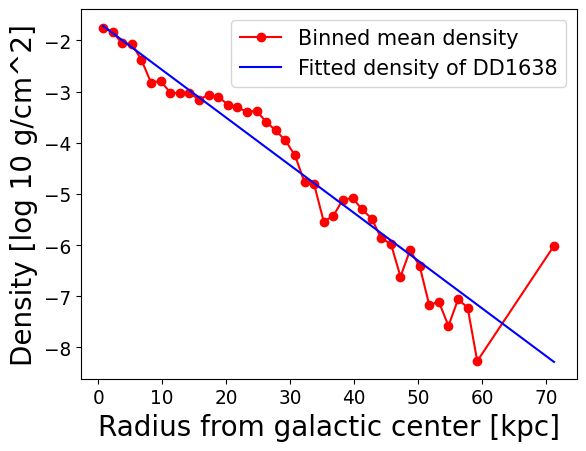

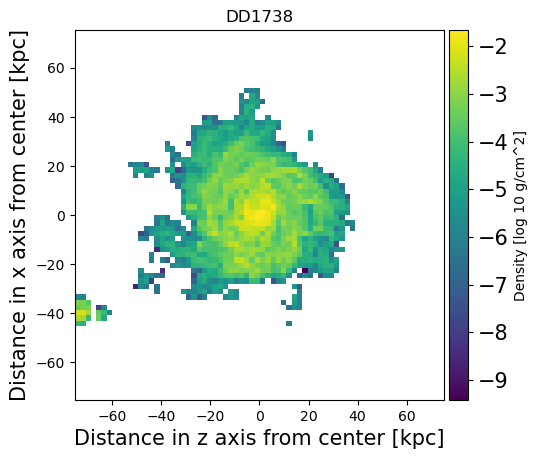

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1838/DD1838


yt : [INFO     ] 2023-07-21 16:41:45,282 Parameters: current_time              = 492.31652781829
yt : [INFO     ] 2023-07-21 16:41:45,282 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-21 16:41:45,283 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-21 16:41:45,284 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-21 16:41:45,285 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-21 16:41:45,285 Parameters: current_redshift          = 0.26978215732692
yt : [INFO     ] 2023-07-21 16:41:45,286 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-21 16:41:45,287 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-21 16:41:45,287 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-07-21 16:41:45,288 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:       col1        col2     col3     col4     col5     col6     col7   col8
--------------- -------- -------- -------- -------- -------- -------- ----
0.2697939304999 0.489703 0.474121 0.506863 0.491703 0.476121 0.508863    9


Parsing Hierarchy : 100%|█████████████████| 5365/5365 [00:00<00:00, 5506.22it/s]
yt : [INFO     ] 2023-07-21 16:41:46,521 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-21 16:42:56,585 Projection completed
yt : [INFO     ] 2023-07-21 16:42:56,586 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/unyt/array.py:1802: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


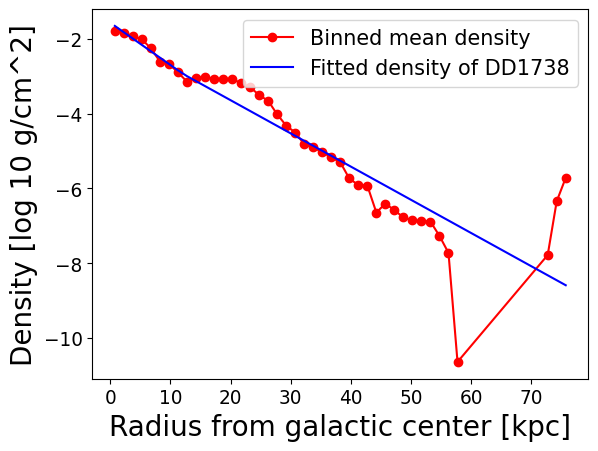

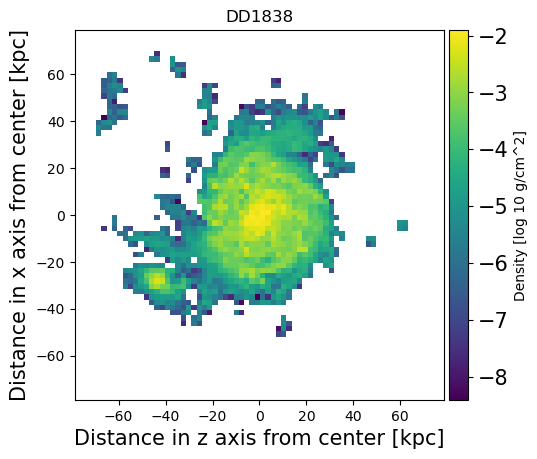

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1938/DD1938


yt : [INFO     ] 2023-07-21 16:42:57,450 Parameters: current_time              = 517.31652781829
yt : [INFO     ] 2023-07-21 16:42:57,451 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-21 16:42:57,451 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-21 16:42:57,452 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-21 16:42:57,453 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-21 16:42:57,454 Parameters: current_redshift          = 0.21639444449422
yt : [INFO     ] 2023-07-21 16:42:57,455 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-21 16:42:57,456 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-21 16:42:57,456 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-07-21 16:42:57,457 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:       col1         col2     col3     col4     col5     col6     col7   col8
---------------- -------- -------- -------- -------- -------- -------- ----
0.21640266677445 0.489548 0.473393 0.507161 0.491548 0.475393 0.509161    9


Parsing Hierarchy : 100%|█████████████████| 4944/4944 [00:00<00:00, 6913.93it/s]
yt : [INFO     ] 2023-07-21 16:42:58,387 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-21 16:44:02,159 Projection completed
yt : [INFO     ] 2023-07-21 16:44:02,160 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/unyt/array.py:1802: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


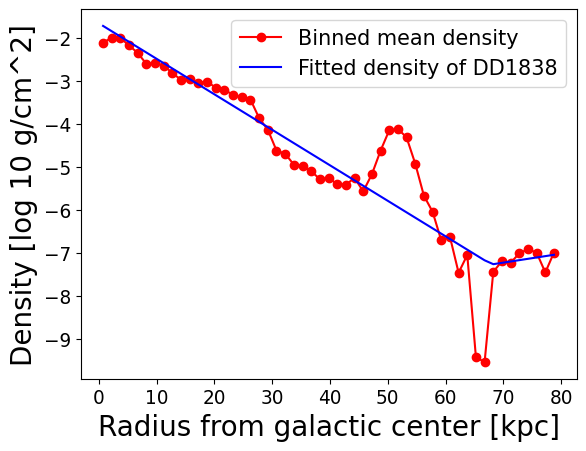

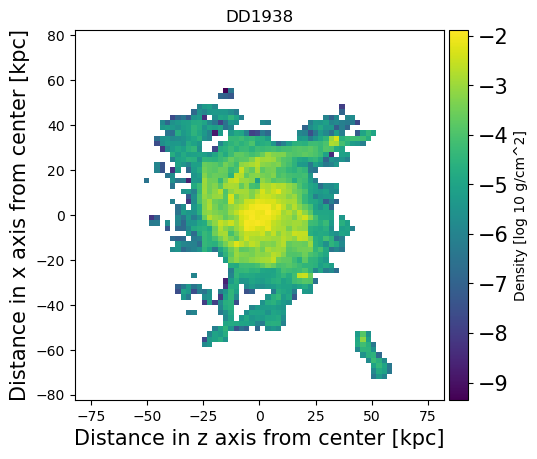

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD2038/DD2038


yt : [INFO     ] 2023-07-21 16:44:03,566 Parameters: current_time              = 542.31652781829
yt : [INFO     ] 2023-07-21 16:44:03,567 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-21 16:44:03,568 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-21 16:44:03,569 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-21 16:44:03,570 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-21 16:44:03,570 Parameters: current_redshift          = 0.1665627895111
yt : [INFO     ] 2023-07-21 16:44:03,571 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-21 16:44:03,571 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-21 16:44:03,572 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-07-21 16:44:03,573 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:       col1         col2     col3     col4     col5     col6     col7   col8
---------------- -------- -------- -------- -------- -------- -------- ----
0.16656997024797 0.489403 0.472708 0.507468 0.491403 0.474708 0.509468    9


Parsing Hierarchy : 100%|█████████████████| 5224/5224 [00:00<00:00, 5881.64it/s]
yt : [INFO     ] 2023-07-21 16:44:04,756 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-21 16:45:09,679 Projection completed
yt : [INFO     ] 2023-07-21 16:45:09,680 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/unyt/array.py:1802: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


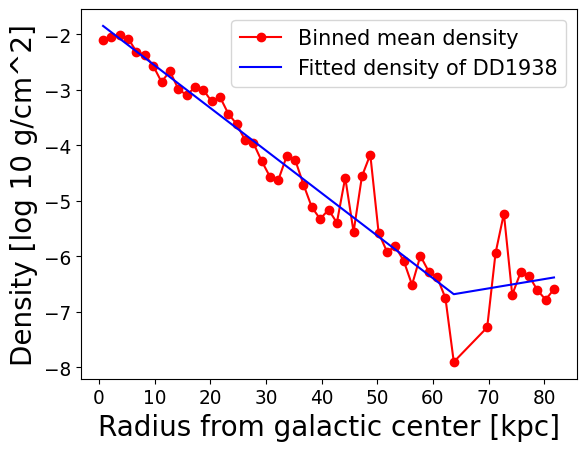

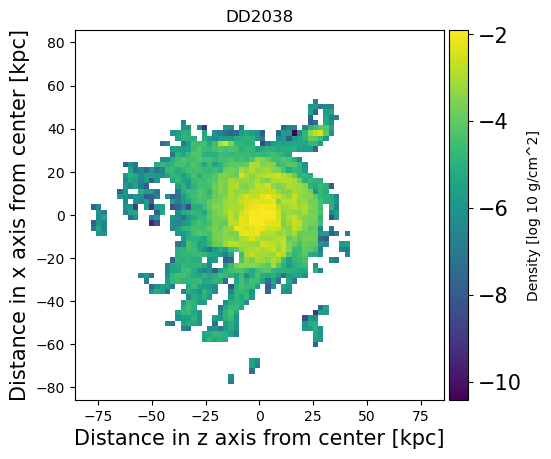

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD2138/DD2138


yt : [INFO     ] 2023-07-21 16:45:10,604 Parameters: current_time              = 567.31652781829
yt : [INFO     ] 2023-07-21 16:45:10,604 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-21 16:45:10,605 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-21 16:45:10,606 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-21 16:45:10,608 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-21 16:45:10,609 Parameters: current_redshift          = 0.11988207020675
yt : [INFO     ] 2023-07-21 16:45:10,609 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-21 16:45:10,610 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-21 16:45:10,611 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-07-21 16:45:10,611 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:       col1         col2     col3     col4     col5     col6     col7   col8
---------------- -------- -------- -------- -------- -------- -------- ----
0.11989107535193 0.489254 0.472056 0.507771 0.491254 0.474056 0.509771    9


Parsing Hierarchy : 100%|█████████████████| 4682/4682 [00:00<00:00, 6972.74it/s]
yt : [INFO     ] 2023-07-21 16:45:11,562 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-21 16:46:13,057 Projection completed
yt : [INFO     ] 2023-07-21 16:46:13,058 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/hylee/anaconda3/lib/python3.10/site-packages/unyt/array.py:1802: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


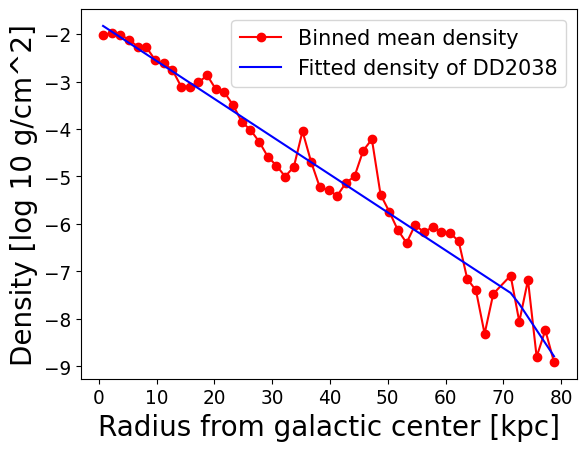

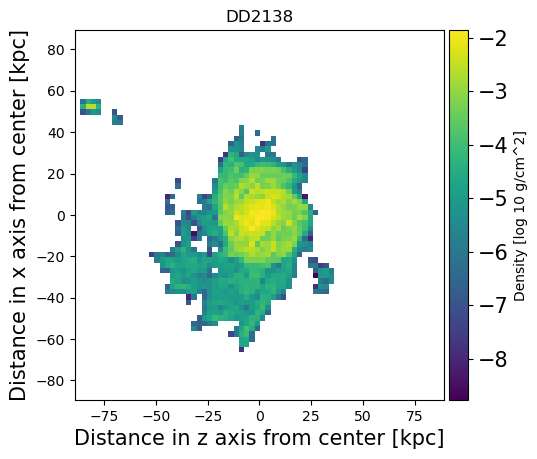

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD2238/DD2238


yt : [INFO     ] 2023-07-21 16:46:13,804 Parameters: current_time              = 592.31652781829
yt : [INFO     ] 2023-07-21 16:46:13,805 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-21 16:46:13,806 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-21 16:46:13,808 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-21 16:46:13,809 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-21 16:46:13,810 Parameters: current_redshift          = 0.076013204837093
yt : [INFO     ] 2023-07-21 16:46:13,810 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-21 16:46:13,811 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-21 16:46:13,812 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-07-21 16:46:13,813 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:        col1         col2     col3     col4     col5     col6     col7   col8
----------------- -------- -------- -------- -------- -------- -------- ----
0.076025451160672 0.489123 0.471432 0.508053 0.491123 0.473432 0.510053    9


Parsing Hierarchy : 100%|█████████████████| 4688/4688 [00:00<00:00, 6264.98it/s]
yt : [INFO     ] 2023-07-21 16:46:14,788 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-21 16:47:13,926 Projection completed
yt : [INFO     ] 2023-07-21 16:47:13,928 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/hylee/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
yt : [INFO     ] 2023-07-21 16:47:14,113 Parameters: current_time              = 604.81652781829
yt : [INFO     ] 2023-07-21 16:47:14,114 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-21 16:47:14,114 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-21 16:47:14,115 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-21 16:47:14,117 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07

Error with DD2238
Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD2288/DD2288
get_refine_box: using this location:        col1         col2     col3     col4     col5     col6     col7   col8
----------------- -------- -------- -------- -------- -------- -------- ----
0.055055663741937 0.489056 0.471131 0.508189 0.491056 0.473131 0.510189    9


Parsing Hierarchy : 100%|█████████████████| 4745/4745 [00:00<00:00, 5310.26it/s]
yt : [INFO     ] 2023-07-21 16:47:15,417 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-21 16:48:20,487 Projection completed
yt : [INFO     ] 2023-07-21 16:48:20,489 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/unyt/array.py:1802: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


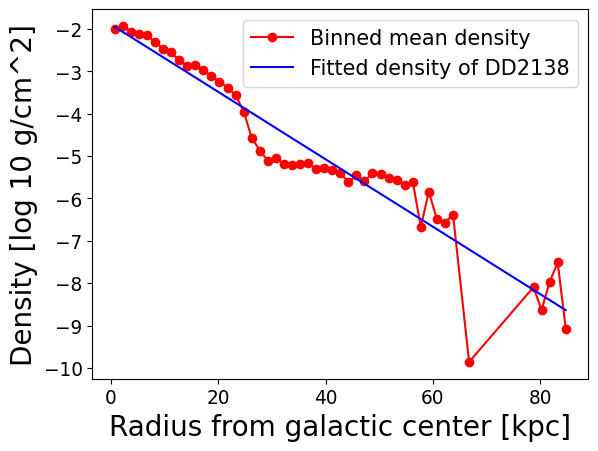

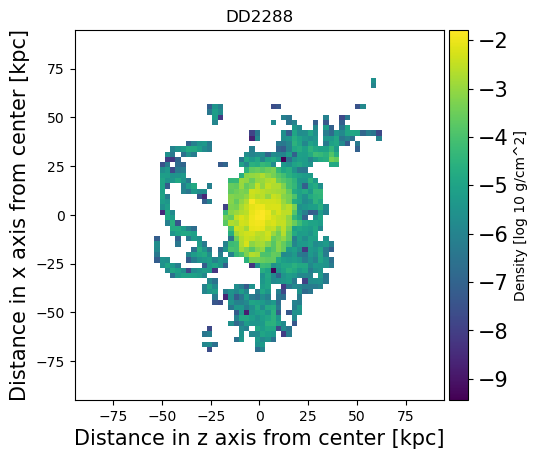

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD2289/DD2289


yt : [INFO     ] 2023-07-21 16:48:21,331 Parameters: current_time              = 605.06652781829
yt : [INFO     ] 2023-07-21 16:48:21,332 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-21 16:48:21,332 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-21 16:48:21,333 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-21 16:48:21,334 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-21 16:48:21,335 Parameters: current_redshift          = 0.054634911934635
yt : [INFO     ] 2023-07-21 16:48:21,335 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-21 16:48:21,336 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-21 16:48:21,337 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-07-21 16:48:21,338 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:        col1         col2     col3     col4     col5     col6     col7   col8
----------------- -------- -------- -------- -------- -------- -------- ----
0.054642475638284 0.489054 0.471125 0.508191 0.491054 0.473125 0.510191    9


Parsing Hierarchy : 100%|█████████████████| 4798/4798 [00:00<00:00, 5559.79it/s]
yt : [INFO     ] 2023-07-21 16:48:22,403 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-21 16:49:27,597 Projection completed
yt : [INFO     ] 2023-07-21 16:49:27,598 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/unyt/array.py:1802: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


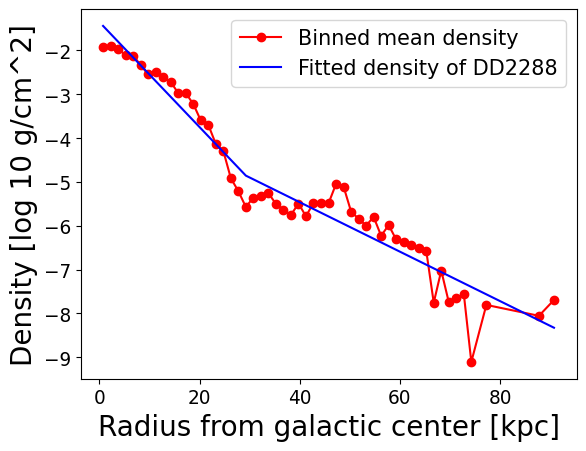

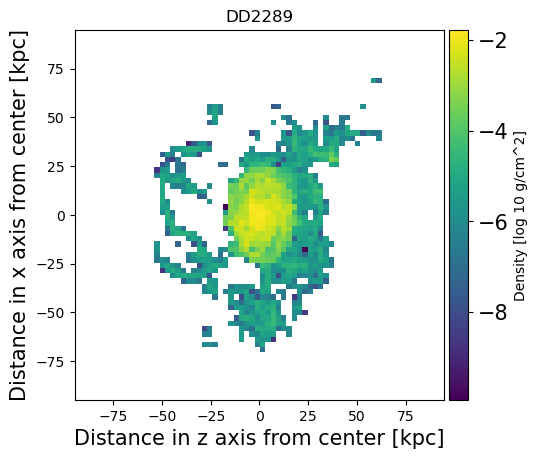

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD2338/DD2338


yt : [INFO     ] 2023-07-21 16:49:28,541 Parameters: current_time              = 617.31652781829
yt : [INFO     ] 2023-07-21 16:49:28,542 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-21 16:49:28,542 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-21 16:49:28,543 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-21 16:49:28,544 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-21 16:49:28,545 Parameters: current_redshift          = 0.034670076640073
yt : [INFO     ] 2023-07-21 16:49:28,545 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-21 16:49:28,546 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-21 16:49:28,547 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-07-21 16:49:28,547 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:        col1         col2     col3     col4    col5     col6     col7  col8
----------------- -------- -------- ------- -------- -------- ------- ----
0.034684446722936 0.488987 0.470833 0.50832 0.490987 0.472833 0.51032    9


Parsing Hierarchy : 100%|█████████████████| 4505/4505 [00:00<00:00, 6622.74it/s]
yt : [INFO     ] 2023-07-21 16:49:29,429 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-21 16:50:30,664 Projection completed
yt : [INFO     ] 2023-07-21 16:50:30,665 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/unyt/array.py:1802: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


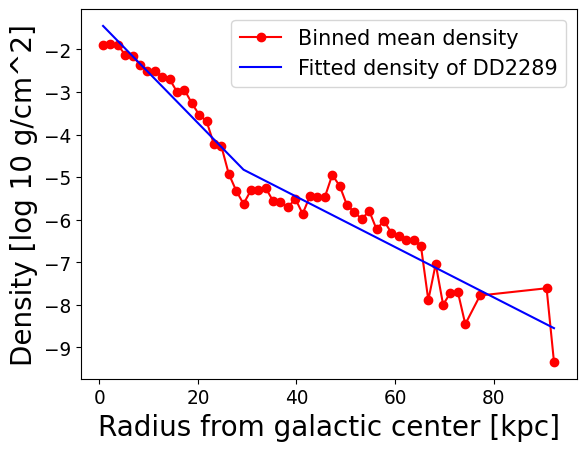

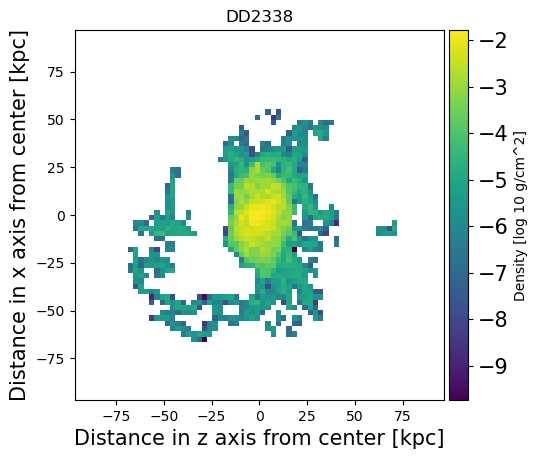

yt : [INFO     ] 2023-07-21 16:50:31,624 Parameters: current_time              = 639.44480357087
yt : [INFO     ] 2023-07-21 16:50:31,625 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-21 16:50:31,625 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-21 16:50:31,626 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-21 16:50:31,627 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-21 16:50:31,628 Parameters: current_redshift          = 0
yt : [INFO     ] 2023-07-21 16:50:31,629 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-21 16:50:31,629 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-21 16:50:31,630 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-07-21 16:50:31,630 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD2427/DD2427
get_refine_box: using this location:         col1          col2     col3     col4    col5     col6     col7  col8
------------------- -------- -------- ------- -------- -------- ------- ----
4.4408920985006e-16 0.488865 0.470316 0.50854 0.490865 0.472316 0.51054    9


Parsing Hierarchy : 100%|█████████████████| 4262/4262 [00:00<00:00, 5247.62it/s]
yt : [INFO     ] 2023-07-21 16:50:32,697 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-21 16:51:31,004 Projection completed
yt : [INFO     ] 2023-07-21 16:51:31,005 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/unyt/array.py:1802: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


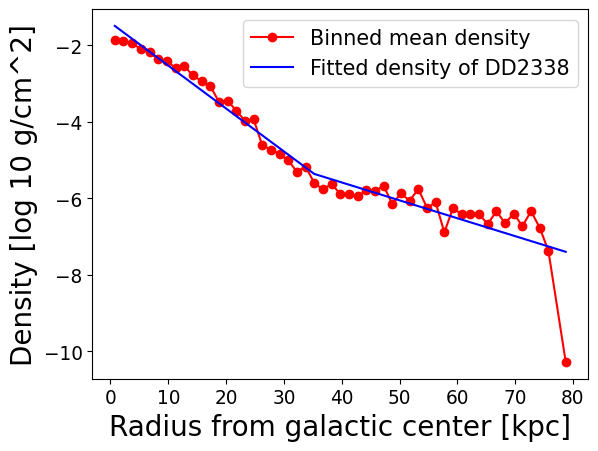

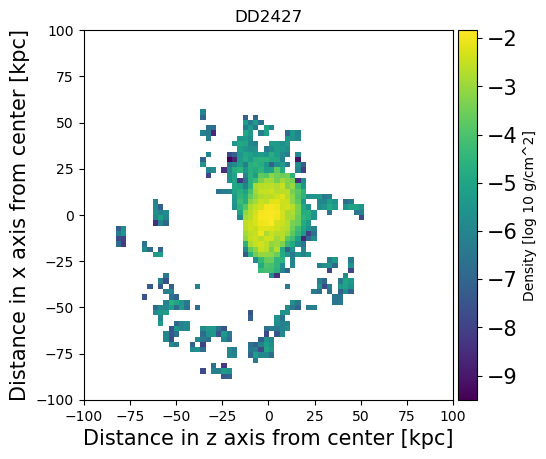

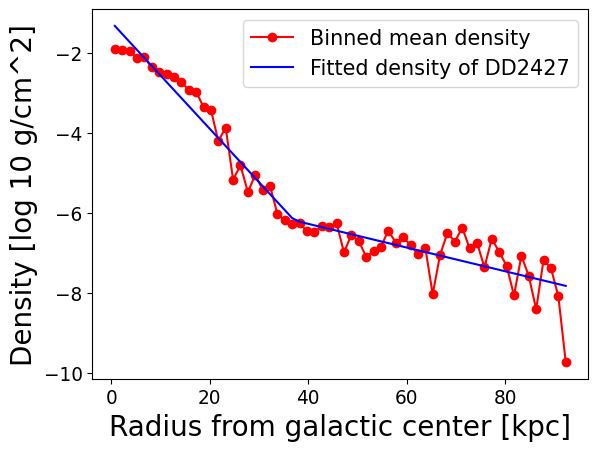

In [9]:
redshiftlist = [] #This part will be replaced with pandas later. 
cutofflist = [] #same 
timelist = [] #same 

for DD in sorted_dd_list:
    try:  
        snap = DD  # name of the snapshot output 
        snap_fullpath = simulation_dir + snap + '/' + snap # full path of where the snapshot output lives
        plotlabel_segment = 'Fitted density of' + " " + snap
        ds, refine_box = foggie_load(snap_fullpath, track_name, halo_c_v_name=track_dir + 'halo_c_v',
                                  disk_relative=False, do_filter_particles=False, masses_dir=track_dir)
        
        z = ds.get_parameter("CosmologyCurrentRedshift")
        current_time = ds.current_time.in_units('Gyr').value
        width = 200/(1+z) #[ckpc/h]
        max_radius = width/2 #[ckpc/h]
        
        rho_cut = get_density_cut(current_time)
        new_refine_box = refine_box.cut_region(['obj["gas", "density"] > %.1E' % rho_cut])
    
        frb = frb_projection(ds, field, axis, new_refine_box, width, resolution, weight_field = None)

        OD_Rad, OD_Qua = radius_func(np.array(frb["gas",field]), width, resolution)

        radiuslist, quantitylist =  binning_func(OD_Rad, OD_Qua, max_radius, min_radius, binsize)
        
        # Code below solves NaN error
        nanmask = [np.where(np.array(quantitylist)!=0)][0]
        new_quantity = np.array(quantitylist)[nanmask]
        new_radius = np.array(radiuslist)[nanmask]
        
        
        p , e = optimize.curve_fit(piecewise_linear, new_radius, np.log10(new_quantity), p0 = [20,1,1,1])
        #p : popt(optimization parameter) / e : pcov(covariance of popt)

        projection_plot = projection(frb, field, width, colorlabel, axis, snap, fontsize = 15)
        segment_plot = plotting(new_radius, np.log10(new_quantity), piecewise_linear(new_radius, *p),
                        'ro-','b-', plotlabel_linedot, plotlabel_segment)
 
        segment_plot.savefig(output_dir + snap + "_Density_Profile.jpg", bbox_inches = 'tight')
        projection_plot.savefig(output_dir + snap + "_Density_Projection_Plot.jpg")
    
        timepara = ds.current_time.in_units('Gyr').value + 0
        redshiftlist.append(z) #[z]
        cutofflist.append(p[0]) #[kpc]
        timelist.append(timepara) #[Gyr]
        
    except:
        print("Error with" +" "+ snap)
        pass     

In [10]:
#pandadata = {'Rdshift' : redshiftlist, 'Current time' : timelist, 'Cut-off radius' : cutofflist}
#Pd_dataframe = pd.DataFrame(data=d)
#Pd_dataframe4

In [11]:
cutofflist

[20.696186349503712,
 25.288966557181627,
 9.021583223856233,
 20.36405431232347,
 7.232940819142514,
 26.25019283014608,
 9.070900983521542,
 8.858076953163348,
 7.631626168295786,
 10.311504996624251,
 23.35215304224265,
 28.328243882904754,
 29.91782626291998,
 30.75014145598151,
 51.467134248644896,
 -31.862316711325665,
 21.750008408679314,
 -45.00691675919035,
 5.2492598709556,
 -14.713472801465919,
 12.16572510630195,
 67.92221571133354,
 63.74999910108114,
 71.64851961468108,
 -50.474255267392394,
 29.249999362682736,
 29.249999622034775,
 35.24998145308881,
 37.187467272094445]

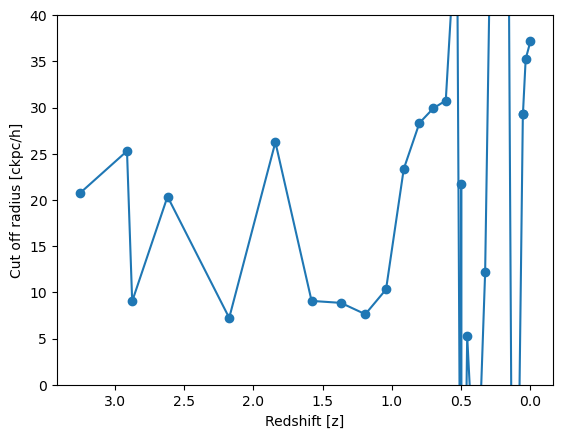

In [12]:
plt.plot(redshiftlist, cutofflist,'-o')
plt.ylabel("Cut off radius [ckpc/h]")
plt.ylim([0,40])
plt.xlabel("Redshift [z]")
plt.gca().invert_xaxis()

In [13]:
cutofflist
#1st, density cut off too aggressive and 2nd, bounds for optimization. no negatifel. 

[20.696186349503712,
 25.288966557181627,
 9.021583223856233,
 20.36405431232347,
 7.232940819142514,
 26.25019283014608,
 9.070900983521542,
 8.858076953163348,
 7.631626168295786,
 10.311504996624251,
 23.35215304224265,
 28.328243882904754,
 29.91782626291998,
 30.75014145598151,
 51.467134248644896,
 -31.862316711325665,
 21.750008408679314,
 -45.00691675919035,
 5.2492598709556,
 -14.713472801465919,
 12.16572510630195,
 67.92221571133354,
 63.74999910108114,
 71.64851961468108,
 -50.474255267392394,
 29.249999362682736,
 29.249999622034775,
 35.24998145308881,
 37.187467272094445]

In [14]:
timelist

[1.991808986859407,
 2.255399516439776,
 2.287675907816951,
 2.5297488431457626,
 3.0676886994320105,
 3.605628555718258,
 4.143568412004506,
 4.681508268290753,
 5.219448124577001,
 5.757387980863249,
 6.289948438586634,
 6.827888294872881,
 7.365828151159129,
 7.903768007445377,
 8.441707863731624,
 8.65150440768326,
 8.656883806246125,
 8.6622631479552,
 8.979647720017873,
 9.51758757630412,
 10.055527432590369,
 10.593467288876615,
 11.131407145162862,
 11.66934700144911,
 12.207286857735356,
 13.014196642164729,
 13.019576040727591,
 13.283166570307852,
 13.759313829436067]

In [15]:
redshiftlist

[3.2538800161868,
 2.9116806075987,
 2.8742891413864,
 2.6192132579666,
 2.174064272558,
 1.8407728906142,
 1.5796008591072,
 1.3679320867642,
 1.1918720434881,
 1.0423765498971,
 0.91449134314195,
 0.80131183964773,
 0.70104740107777,
 0.61132831909135,
 0.53034842583426,
 0.50082158855578,
 0.50007848881181,
 0.49933608114367,
 0.45670560906839,
 0.3892837031507,
 0.32721407621449,
 0.26978215732692,
 0.21639444449422,
 0.1665627895111,
 0.11988207020675,
 0.055049291735707,
 0.054634911934635,
 0.034670076640073,
 0]